Sampling from GPs
=================

In [21]:
import numpy as np, scipy
%matplotlib agg
from matplotlib import pyplot as plt
from matplotlib import animation
import itertools
import GPy


from matplotlib import rc


from matplotlib import cm
rc('text', usetex=True)
#from JSAnimation.IPython_display import display_animation

# Choose here whether to sample from a fitted GP or zero mean samples:

In [22]:
420 * (16/9)

746.6666666666666

In [23]:
# Switch for wether to use the data from toy_rbf to plot. 
# if true, we wont use the data, if false we will
zero_mean = True

# switch for 1d or 2d
one_d = True

In [26]:
# First set up the figure, the axis, and the plot element we want to animate
plt.close('all')
if one_d: 
    fig = plt.figure(figsize=(4.2*(16/9), 4.20))
    vl_list = [(1,2), (1,.8), (1,.5)]
    colors = ["#BBCDD9","#2A3F54","#5A9ED2","#687C8E"] # tahnks to http://tools.medialab.sciences-po.fr/iwanthue/index.php

    m = GPy.examples.regression.toy_rbf_1d_50(plot=False)
    #m.plot(ax=ax)
else:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    vl_list = [(1,1)]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

In [27]:
if one_d:
    ks = [GPy.kern.RBF(1, variance=v, lengthscale=l) for v,l in vl_list]
    N = 100
    mi, ma = m.X.min(), m.X.max()
    r = m.X.max() - m.X.min()
    x = np.linspace(mi-r, ma+r, N)[:,None]

    ax = fig.add_subplot(111, xlim=(mi-r, ma+r), ylim=(-4, 4))
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    from GPy.plotting.matplot_dep.plot_definitions import MatplotlibPlots
    mat_plot = MatplotlibPlots()
    
    if zero_mean:
        # Plot just samples:
        l_nothing = ax.plot(x, np.zeros_like(x), c='#687C8E', lw=2)[0]
        #ax.fill_between(x[:,0], np.zeros(x.shape[0])+2, np.zeros(x.shape[0])-2, facecolor='#BBCDD9', alpha=.2)
        K = ks[2].K(x)
        mu = np.zeros(K.shape[0])
        s = np.random.multivariate_normal(mu.squeeze(), K, size=(10000)).T
        percs = np.percentile(s, np.linspace(0, 100, 75), overwrite_input=True, axis=1)
        mat_plot.fill_gradient(ax, x[:,0], percs, color='#687C8E', linewidth=0, alpha=1.)
        #l_nothing = GPy.plotting.matplot_dep.base_plots.gpplot(
        #    x, np.zeros_like(x), np.zeros_like(x)+2, np.zeros_like(x)-2, 
        #    ax=ax, edgecol='#3300FF', fillcol='#BBCDD9')[0][0]
        #mat_plot.fill_gradient(ax, )
        ax.set_ylim(-3,3)
    else:
        # Plot with mean:
        l_nothing = m.plot_mean(ax=ax, plot_limits=(mi-r,ma+r), label='mean')
        #l_nothing = m.plot(ax=ax, plot_limits=(mi-r,ma+r))['gpmean'][0][0]
        density = m.plot_density(ax=ax, plot_limits=(mi-r,ma+r), label='density')
        m.plot_data(ax=ax, label='data')

    lines = [ax.plot(
        np.linspace(-1,1,100), 
        np.sin(np.linspace(-1,1,100)-np.random.randn()), lw=.8, 
        color=c, 
        label=r'$\ell={:.2G}$'.format(l))[0] for (v,l),c in zip(vl_list, colors)
    ]

    #legend = ax.legend(
    legend = ax.legend(
        bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
        ncol=3, mode="expand", borderaxespad=0.
    )
else:
    ks = [GPy.kern.Matern32(2, lengthscale=2)]
    X, Y = np.mgrid[-5:5:40j, -5:5:40j]
    N = X.size
    x = np.c_[X.flat, Y.flat]
    Ks = [ks[0].K(x)]
    Z = np.random.multivariate_normal(np.zeros(x.shape[0]), Ks[0])
    ax.plot_surface(X, Y, Z.reshape(X.shape[0], Y.shape[1]), cmap=cm.jet, rstride=1, cstride=1)
    
fig.tight_layout(rect=(0, 0, 1, .98))


In [39]:
ax.plot([], [], lw=.8, color=colors[0])

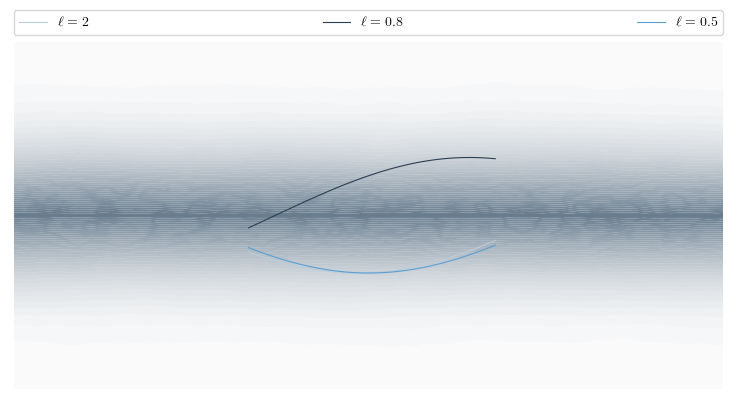

In [28]:
fig

In [29]:
if one_d:
    if zero_mean:
        mus = [np.zeros_like(x) for _ in vl_list]
        Ks = [k.K(x) for k in ks]
    else:
        mu, K = m._raw_predict(x, full_cov=True)
        mus = [mu for _ in vl_list]
        Ks = [K for _ in vl_list]

In [30]:
#plt.matshow(Ks[0])

#ax.plot(x,np.zeros(N),color='k',lw=2,ls='--')
#ax.fill_between(x[:,0],np.ones(N)*2,-np.ones(N)*2,color='k',alpha=.2,linestyle='--')

Rs = [GPy.util.linalg.pdinv(K+np.eye(N)*1e-8)[1] for K in Ks]

In [31]:
from animate_gp import animation_matrix

frames = 100
draws = [animation_matrix(N,frames) for _ in vl_list]

In [32]:
# initialization function: plot the background of each frame
if one_d:
    def init():
        for line in lines:
            line.set_data([], [])
        return lines
else:
    def init():
        del ax.collections[:]
        return [ax.plot_surface(X, Y, Z.reshape(X.shape[0], Y.shape[1]), cmap=cm.jet, rstride=1, cstride=1)]

In [33]:
# animation function.  This is called sequentially
s = [R.dot(draw) for R,draw in zip(Rs,draws)]
if one_d:
    def animate(i):
        for sprime, mu, line in zip(s, mus, lines):
            #print y[:,i].shape, x.shape
            line.set_data(x[:,0], mu[:,0]+sprime[:,i])
        return lines
else:
    def animate(i):
        del ax.collections[:]
        ax.set_zlim(-5,5)
        return [ax.plot_surface(X, Y, s[0][:,i].reshape(X.shape[0], Y.shape[1]), cmap=cm.jet, rstride=1, cstride=1)]
animate(1)

In [34]:
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=20, blit=False, 
                               repeat=True, save_count=frames,
                              )
#plt.show()

In [35]:
writer = animation.FFMpegFileWriter(
    fps=30,
    codec='libx264',
    #frame_format='jpeg',
    extra_args=[
        #'-vf', 'format=yuv420p',
        '-pix_fmt', 'yuva420p',
    ], 
    )
anim.save(
    'gp_animation_mean.mp4', 
    writer=writer,
    dpi=150,
    savefig_kwargs={'transparent': False, 'facecolor': 'white'},
)

In [36]:
jshtml = anim.to_jshtml()

In [37]:
from IPython.display import HTML
HTML(jshtml)

In [32]:
html = anim.to_html5_video()

In [17]:
from IPython.display import HTML
HTML(html)

In [18]:
# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
import os
for i in range(frames):
    if not one_d:
        animate(i)
        fig.canvas.draw()
        os.makedirs('anims/gp_animation/2D/', exist_ok=True)
        fig.savefig('anims/gp_animation/2D/matern_anim{:0>3}.png'.format(i))
        #anim.save('gp_animation_zero_mean.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    elif zero_mean:
        animate(i)
        fig.canvas.draw()
        os.makedirs('anims/gp_animation/zero_mean/', exist_ok=True)
        fig.savefig('anims/gp_animation/zero_mean/anim{:0>3}.png'.format(i))
        #anim.save('gp_animation_zero_mean.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    else:
        animate(i)
        fig.canvas.draw()
        os.makedirs('anims/gp_animation/mean/', exist_ok=True)
        fig.savefig('anims/gp_animation/mean/anim{:0>3}.jpg'.format(i))
        #anim.save('gp_animation_mean.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

In [160]:
if zero_mean:
    fig.savefig('gp_animation_zero_mean_poster.pdf')
else:
    fig.savefig('gp_animation_mean_poster.pdf')

In [ ]:
def exp_map_sphere(mu, E):
    theta = np.sqrt((E**2).sum(0))[None, :]
    M = mu * np.sin(theta)
    M = M + (E * (np.cos(theta))/theta)
    M[:, np.abs(theta[0])<=1e-7] = mu
    return M

def exp_map(mu, E):
    theta = np.sqrt((E**2).sum(0))[None]
    M = mu * np.sin(theta)
    M = M + (E * (np.cos(theta))/theta)
    M[:, np.abs(theta[0])<=1e-7] = mu
    return M

def gp_animate(d,n):
    u = np.random.normal(0,1,size=(N,1))
    r = np.sqrt((u**2).sum())
    u /= r
    t = np.random.normal(0,1,size=(N,1))
    t = t - (t.T.dot(u)).dot(u.T).T
    t /= np.sqrt((t**2).sum())
    start = np.random.uniform(0,2*np.pi)
    T = np.linspace(start, start+2*np.pi, n)[None, :] * t
    return r*exp_map(u, np.linspace(0.001, 2*np.pi, n)[None] * t)